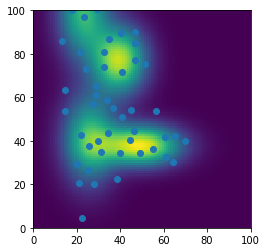

In [56]:
from __future__ import print_function
import math
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import torch
import torch.distributions.constraints as constraints
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist

np.random.seed(50)

forest_edge_size = 100

# Density of fertilizer is represented
# as a combination of gaussians
# truncated within a given region
n_fertilizer_source_locations = 4
fertilizer_source_locations = np.random.random( (2, n_fertilizer_source_locations) ) * forest_edge_size
fertilizer_source_variances = np.random.uniform( low=5.0, high=15.0, size=(2, n_fertilizer_source_locations) )

def forest_generator():
    min_intertree_distance = 4.
    num_trees = 50
    trees = np.empty((2, num_trees))
    assignments = np.empty(num_trees)
    for tree_i in range(num_trees):
        while True:
            # Randomly sample a tree from one of the fertilizer source locations
            source_dist_k = np.random.randint(0, n_fertilizer_source_locations)
            candidate_location = np.random.normal(fertilizer_source_locations[:, source_dist_k],
                                                  fertilizer_source_variances[:, source_dist_k])
            # Check distance to all other trees so far
            # if this isn't the first tree
            if tree_i == 0:
                break
            
            closest_distance = np.min(
                np.linalg.norm(np.tile(candidate_location, (tree_i, 1)).T - trees[:, :tree_i],
                               axis=0))
            if closest_distance >= min_intertree_distance:
                break  
        trees[:, tree_i] = candidate_location
        assignments[tree_i] = source_dist_k

    return trees, assignments

def calc_fertilizer_density(locations):
    var_list = [scipy.stats.multivariate_normal(mean=fertilizer_source_locations[:, i],
                                                cov=np.diag(fertilizer_source_variances[:, i]**2))
                for i in range(n_fertilizer_source_locations)]
    return sum(var.pdf(locations) for var in var_list)

trees, gt_assignments = forest_generator()

fig, ax = plt.subplots(1, 1)
ax.scatter(trees[0, :], trees[1, :])

X, Y = np.meshgrid(np.linspace(0, forest_edge_size, 100),
                   np.linspace(0, forest_edge_size, 100))
positions = np.vstack([X.ravel(), Y.ravel()]).T
p = np.reshape(calc_fertilizer_density(positions).T, X.shape).T
ax.imshow(np.rot90(p), extent=[0, forest_edge_size, 0, forest_edge_size])

In [72]:
from __future__ import print_function
from collections import defaultdict
import math
import os
import torch
import torch.distributions.constraints as constraints
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate
import pyro.distributions as dist

#torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.set_default_tensor_type('torch.DoubleTensor')

n_steps = 200

# enable validation (e.g. validate parameters of distributions)
pyro.enable_validation(True)
pyro.distributions.enable_validation(True)

# clear the param store in case we're in a REPL
pyro.clear_param_store()
pyro.set_rng_seed(42)

# Assume trees are generated from above method
def model(data):
    num_trees = data.shape[1]
    
    weights = pyro.param('weights', 
                         torch.ones(n_fertilizer_source_locations) / n_fertilizer_source_locations,
                         constraint=constraints.simplex)
    
    # Fertilizer distribution
    #locs = torch.tensor(fertilizer_source_locations)
    locs = pyro.param('locs',
               torch.tensor(fertilizer_source_locations),
           #           #torch.rand((2, n_fertilizer_source_locations))*forest_edge_size,
               constraint=constraints.interval(0, forest_edge_size))
    
    scales = pyro.param('vars',
                        10 * torch.rand((2, n_fertilizer_source_locations)) + 5,
                        constraint=constraints.interval(5., 15.))
    
    for i in pyro.irange("assignment_iter", num_trees):
        assi = pyro.sample('assignment_%d' % i,
                                 dist.Categorical(weights))
        pyro.sample('tree_%d' % i, 
                    dist.MultivariateNormal(locs[:, assi], torch.diag(scales[:, assi])),
                    obs=data[:, i])

def guide(data):
    num_trees = data.shape[1]

    even_weights = torch.ones(n_fertilizer_source_locations) / n_fertilizer_source_locations
        
    # Randomly sample each tree from one of the fertilizer source locations
    # independently
    for i in pyro.irange('assignment_iter', num_trees):
        assignment_probs = pyro.param('assignment_probs_%d' % i, even_weights,
                              constraint=constraints.simplex)
        pyro.sample('assignment_%d' % i, dist.Categorical(assignment_probs))
        

data = torch.tensor(trees)

# setup the optimizer and inference algorithm
optim = pyro.optim.Adam({'lr': 0.2, 'betas': [0.9, 0.99]})
inference = SVI(model, guide, optim, loss=Trace_ELBO(max_iarange_nesting=1, num_particles=3))

# Register hooks to monitor gradient norms.
gradient_norms = defaultdict(list)
inference.loss(model, guide, data)  # Initializes param store.
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

losses = []
for i in range(n_steps):
    loss = inference.step(data)
    losses.append(loss)
    print('.' if i % 100 else '\n', end='')


...................................................................................................
...................................................................................................

In [59]:
for i in range(500):
    loss = inference.step(data)
    losses.append(loss)
    print('' if i % 100 else '.', end='')

.....

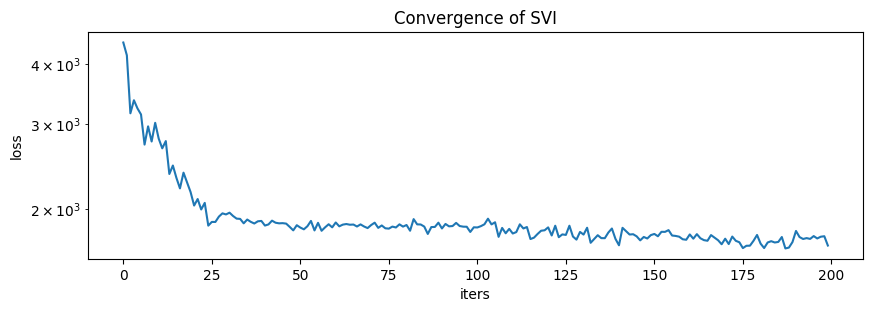

In [73]:
plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Convergence of SVI');

locs:  [[31.70426554 39.31594454 37.67548749 37.36610053]
 [64.22847704 79.7935979  54.81867003 51.11258304]]
gt locs:  [[49.46016455 22.80831044 25.54739238 39.63299097]
 [37.73150977 99.65742302 40.81972003 77.18939948]]
varis:  [[14.98066629 14.97142502 14.94713564 14.9907026 ]
 [14.98126062 14.99983869 14.96321489 14.96670379]]
weights:  [0.27900353 0.120246   0.29646134 0.30428913]
aps 0 with real assign 1:  [0.96115705 0.00108114 0.00196827 0.03579354]
aps 1 with real assign 3:  [9.95585907e-01 3.11007061e-04 5.42081457e-04 3.56100464e-03]
aps 2 with real assign 3:  [0.00194002 0.00263602 0.99047888 0.00494508]
aps 3 with real assign 2:  [0.00873114 0.01468272 0.00460853 0.97197761]
aps 4 with real assign 2:  [0.00224817 0.00790395 0.98836379 0.0014841 ]
aps 5 with real assign 1:  [0.06947954 0.91903065 0.00504913 0.00644067]
aps 6 with real assign 0:  [0.96818622 0.01685882 0.01310859 0.00184637]
aps 7 with real assign 3:  [0.01595622 0.00125425 0.00588661 0.97690291]
aps 8 with

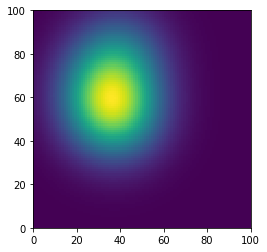

In [74]:
# grab the learned variational parameters
locs = pyro.param("locs").detach().numpy()
#locs = fertilizer_source_locations
varis = pyro.param("vars").detach().numpy()
weights = pyro.param("weights").detach().numpy()
print("locs: ", locs)
print("gt locs: ", fertilizer_source_locations)
print("varis: ", varis)
print("weights: ", weights)

for i in range(20):
    aps = pyro.param("assignment_probs_%d" % i).detach().numpy()
    print("aps %d with real assign %d: " % (i, gt_assignments[i]), aps)

def calc_fertilizer_density(locations):
    var_list = [scipy.stats.multivariate_normal(mean=locs[:, i],
                                                cov=np.diag(varis[:, i]**2))
                for i in range(n_fertilizer_source_locations)]
    return sum(var.pdf(locations) for var in var_list)

fig, ax = plt.subplots(1, 1)

X, Y = np.meshgrid(np.linspace(0, forest_edge_size, 100),
                   np.linspace(0, forest_edge_size, 100))
positions = np.vstack([X.ravel(), Y.ravel()]).T
p = np.reshape(calc_fertilizer_density(positions).T, X.shape).T
ax.imshow(np.rot90(p), extent=[0, forest_edge_size, 0, forest_edge_size])